In [6]:
import numpy as np
import pandas as pd
import torch
import random

In [7]:
CUDA_LAUNCH_BLOCKING=1

In [8]:
#ensuring reproduciblity
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
#loading the data
df = pd.read_csv('GRCh38-cCREs_out.tsv', sep='\t')
#Extracting feature arrays
kid_cols = [c for c in df.columns if c.startswith("kid_")]
mask_cols = [c for c in df.columns if c.startswith("mask_")]

In [10]:
vocab_size = 4**3 + 1
#defining the variables and target variable
X = df[kid_cols].fillna(vocab_size - 1).values.astype(np.int32)
mask = df[mask_cols].values.astype(bool)
y=df['enhancer_label'].values.astype(np.float32)
tissue_labels = df[[c for c in df.columns if c.startswith('active_')]].values.astype(np.float32)


In [11]:
#splitting the data
from sklearn.model_selection import train_test_split

#1st split for training and evaluation
X_train, X_temp, mask_train, mask_temp, y_train, y_temp, tissue_train, tissue_temp = train_test_split(
    X, mask, y, tissue_labels, test_size=0.20, random_state = random_seed, stratify=y)
#2nd split for final testing
X_val, X_test, mask_val, mask_test, y_val, y_test, tissue_val, tissue_test = train_test_split(
    X_temp, mask_temp, y_temp, tissue_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)


In [12]:
from torch.utils.data import Dataset, DataLoader
num_tissues = tissue_labels.shape[1]
#creating our dataset class
class DNAdataset(Dataset):
    def __init__(self, X, y, tissue_labels=None, mask=None, ):
        if isinstance(X, torch.Tensor):
            self.X = X.long()
        else:
            self.X = torch.tensor(X, dtype=torch.long)
        if isinstance(y, torch.Tensor):
            self.y = y.float()
        else:
            self.y = torch.tensor(y, dtype=torch.float32)
        if self.y.dim() == 1:
            self.y = self.y.unsqueeze(-1)
        if tissue_labels is None:
            self.tissue_labels = torch.zeros(len(X), num_tissues, dtype=torch.float32)
        else:
            if isinstance(tissue_labels, torch.Tensor):
                self.tissue_labels = tissue_labels.detach().clone().float()
            else:
                self.tissue_labels = torch.tensor(tissue_labels, dtype=torch.float32)
        if mask is None:
            self.mask = None
        else:
            if isinstance(mask, torch.Tensor):
                self.mask= mask.detach().clone().bool()
            else:
                self.mask = torch.tensor(mask, dtype=torch.bool)
        n= len(self.X)
        assert len(self.y) == n, f"y length mismatch: {len(self.y)} vs {n}"
        assert len(self.tissue_labels) == n, f"tissue_labels length mismatch: {len(self.tissue_labels)} vs {n}"
        assert len(self.mask) == n, f"mask length mismatch: {len(self.mask)} vs {n}"
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        tissue_label = self.tissue_labels[idx]
        mask = self.mask[idx] if self.mask is not None else None
        if mask is not None and not mask.any():
            tissue_label = torch.zeros_like(tissue_label)
        return x, y, tissue_label, mask


In [13]:

#Loading training, testing, validation datasets
train_df = pd.read_csv('train.csv', low_memory=False).dropna(subset=['enhancer_label'])
test_df = pd.read_csv('test.csv', low_memory=False).dropna(subset=['enhancer_label'])
val_df = pd.read_csv('validation.csv', low_memory=False).dropna(subset=['enhancer_label'])

# Identify column types
kid_cols = [col for col in train_df.columns if col.startswith('kid_')]
mask_cols = [col for col in train_df.columns if col.startswith('mask_')]
tissue_cols = [col for col in train_df.columns if col.startswith('tissue_')]

# Define num_tissues globally so it's available for DNAdataset and DNA_CNN
num_tissues = len(tissue_cols)

# Extract data for training set
X_train = train_df[kid_cols].values
y_train = train_df['enhancer_label'].values.astype(np.float32)
mask_train = train_df[mask_cols].values.astype(bool)
tissue_train = train_df[tissue_cols].values.astype(np.float32)

# Extract data for validation set
X_val = val_df[kid_cols].values
y_val = val_df['enhancer_label'].values.astype(np.float32)
mask_val = val_df[mask_cols].values.astype(bool)
tissue_val = val_df[tissue_cols].values.astype(np.float32)

# Extract data for test set
X_test = test_df[kid_cols].values
y_test = test_df['enhancer_label'].values.astype(np.float32)
mask_test = test_df[mask_cols].values.astype(bool)
tissue_test = test_df[tissue_cols].values.astype(np.float32)


#Assigning dataset to our training and validation data
training_data = DNAdataset(X_train, y_train,tissue_train, mask_train)
validation_data = DNAdataset(X_val, y_val,tissue_val, mask_val)
#Defining our data loader
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)


In [14]:
#Ensuring same length and avoiding shape mismatch
min_len = min(len(X), len(y), len(tissue_labels), len(mask))
X, y, tissue_labels, mask = X[:min_len], y[:min_len], tissue_labels[:min_len], mask[:min_len]

**CNN**

In [15]:
import torch.nn as nn
import torch.nn.functional as F
#Creating our CNN model
num_tissues = tissue_labels.shape[1]

#Embedding parameters
embed_dim = 16

class DNA_CNN(nn.Module):
    #Creating convolutional neural network architecture
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab_size-1)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(128, 256, kernel_size = 5, padding = 2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        #Enhancer prediction (binary)
        self.fc_enhancer = nn.Linear(256, 1)
        #Tissue prediction (multi-class)
        self.fc_tissue = nn.Linear(256, num_tissues)
    def forward(self, X):
        X = self.embedding(X).permute(0,2,1)
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = self.pool(X).squeeze(-1)
        #Output layers
        enhancer_output = self.fc_enhancer(X)
        tissue_output = self.fc_tissue(X)

        return enhancer_output, tissue_output


In [16]:
#To accelerate training
torch.set_num_threads(16)

In [17]:
#Defining the model
model = DNA_CNN()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
#Loss function
bce = nn.BCEWithLogitsLoss()
#Loss function for tissue to address class imbalance
#1. computing pos_weight for tissue labels
tissue_train_tensor = torch.tensor(tissue_train, dtype=torch.float32).to(device)
tissue_positive = tissue_train_tensor.sum(dim=0)
tissue_negative = len(tissue_train) - tissue_positive
pos_weight = tissue_negative / tissue_positive
pos_weight = pos_weight.to(device)
bce_tissue = nn.BCEWithLogitsLoss(pos_weight=pos_weight) #weighted BCE for tissue
#Optimizer function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [18]:
train_losses_cnn = []
val_losses_cnn_history = [] # To store validation losses for early stopping

patience = 5
min_delta = 0.0001
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(100):
    model.train()
    total_loss= 0
    for X,y, tissue_labels, mask in train_loader:
        X, y, tissue_labels, mask = X.to(device), y.to(device), tissue_labels.to(device), mask.to(device)
        optimizer.zero_grad()
        predicted_enhancer, predicted_tissue = model(X)
        #Computing the loss
        loss_enhancer = bce(predicted_enhancer.view(-1), y.view(-1))
        #Tissue loss only for active enhancers
        active_idx = mask.any(dim=1)
        if active_idx.any():
            loss_tissue = bce_tissue(predicted_tissue[active_idx], tissue_labels[active_idx])
        else:
            loss_tissue = torch.tensor(0.0, device=device)
        loss = loss_enhancer +  1.0 * loss_tissue
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    Avg_train_loss = total_loss/len(train_loader)
    train_losses_cnn.append(Avg_train_loss)

    # Validation step for early stopping
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for X,y, tissue_labels_batch, mask_batch in validation_loader:
            X,y, tissue_labels_batch, mask_batch = X.to(device),y.to(device), tissue_labels_batch.to(device), mask_batch.to(device)
            predicted_enhancer, predicted_tissue = model(X)
            loss_enhancer_val = bce(predicted_enhancer.view(-1), y.view(-1))
            active_idx_val = mask_batch.any(dim=1)
            if active_idx_val.any():
                loss_tissue_val = bce_tissue(predicted_tissue[active_idx_val], tissue_labels_batch[active_idx_val])
            else:
                loss_tissue_val = torch.tensor(0.0, device=device)
            validation_loss += (loss_enhancer_val + 1.0 * loss_tissue_val).item()
    Avg_val_loss = validation_loss / len(validation_loader)
    val_losses_cnn_history.append(Avg_val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {Avg_train_loss:.4f}, Val Loss: {Avg_val_loss:.4f}')

    # Early stopping logic
    if best_val_loss - Avg_val_loss > min_delta:
        best_val_loss = Avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_cnn_model.pth') # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss.")
            break

# Load the best model if early stopping was used
if 'best_cnn_model.pth' in globals() or 'best_cnn_model.pth' in locals(): # Check if it was saved
    model.load_state_dict(torch.load('best_cnn_model.pth'))

Epoch 1, Train Loss: 1.8459, Val Loss: 1.8575
Epoch 2, Train Loss: 1.8040, Val Loss: 1.8528
Epoch 3, Train Loss: 1.8257, Val Loss: 1.8486
Epoch 4, Train Loss: 1.7650, Val Loss: 1.8454
Epoch 5, Train Loss: 1.7519, Val Loss: 1.8446
Epoch 6, Train Loss: 1.8122, Val Loss: 1.8406
Epoch 7, Train Loss: 1.7596, Val Loss: 1.8336
Epoch 8, Train Loss: 1.7313, Val Loss: 1.8341
Epoch 9, Train Loss: 1.7329, Val Loss: 1.8326
Epoch 10, Train Loss: 1.7399, Val Loss: 1.8343
Epoch 11, Train Loss: 1.6997, Val Loss: 1.8225
Epoch 12, Train Loss: 1.6916, Val Loss: 1.8235
Epoch 13, Train Loss: 1.6946, Val Loss: 1.8246
Epoch 14, Train Loss: 1.7141, Val Loss: 1.8226
Epoch 15, Train Loss: 1.6681, Val Loss: 1.8096
Epoch 16, Train Loss: 1.6517, Val Loss: 1.8104
Epoch 17, Train Loss: 1.6604, Val Loss: 1.8077
Epoch 18, Train Loss: 1.6606, Val Loss: 1.8021
Epoch 19, Train Loss: 1.6429, Val Loss: 1.7986
Epoch 20, Train Loss: 1.6234, Val Loss: 1.8008
Epoch 21, Train Loss: 1.5951, Val Loss: 1.7951
Epoch 22, Train Loss: 

In [19]:
#reusing validation loss history for plotting
val_loss_cnn = val_losses_cnn_history


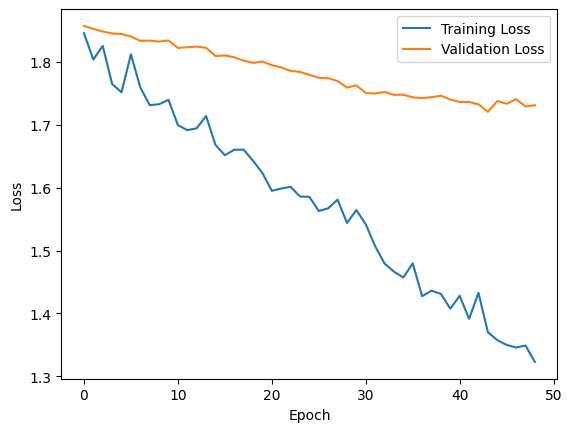

In [20]:
import matplotlib.pyplot as plt
#plotting the loss curves
plt.plot(train_losses_cnn, label='Training Loss')
plt.plot(val_loss_cnn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
#Computing the evaluation metrics
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#Evaluation of our CNN model
model.eval()
all_enhancer_logits, all_enhancer_true = [], []
all_tissue_logits, all_tissue_true = [], []

with torch.no_grad():
  for X,y, tissue_labels, mask in validation_loader:
    X,y, tissue_labels, mask = X.to(device),y.to(device), tissue_labels.to(device), mask.to(device)
    predicted_enhancer, predicted_tissue = model(X)

    all_enhancer_logits.append(predicted_enhancer.cpu())
    all_enhancer_true.append(y.cpu())
    all_tissue_logits.append(predicted_tissue.cpu())
    all_tissue_true.append(tissue_labels.cpu())

all_enhancer_logits = torch.cat(all_enhancer_logits, dim=0)
all_enhancer_true = torch.cat(all_enhancer_true, dim=0)
all_tissue_logits = torch.cat(all_tissue_logits, dim=0)
all_tissue_true = torch.cat(all_tissue_true, dim=0)

#Threshold tuning for enhancer
best_Thresh_enhancer, best_f1_enhancer = 0.5, 0
for t in np.arange(0.3, 0.7, 0.5):
  predicted = (torch.sigmoid(all_enhancer_logits) > t).int().numpy()
  f1 = f1_score(all_enhancer_true.numpy().flatten(), predicted.flatten())
  if f1 > best_f1_enhancer:
    best_f1_enhancer = f1
    best_Thresh_enhancer = t
#Threshold tuning for tissue
best_Thresh_tissue, best_f1_tissue = 0.5, 0
for t in np.arange(0.3, 0.7, 0.05):
  predicted = (torch.sigmoid(all_tissue_logits) > t).int().numpy()
  f1 = f1_score(all_tissue_true.numpy().flatten(), predicted.flatten())
  if f1 > best_f1_tissue:
    best_f1_tissue = f1
    best_Thresh_tissue = t

#computing final metrics
enhancer_predicted = (torch.sigmoid(all_enhancer_logits) > best_Thresh_enhancer).int().numpy()
enhancer_true = all_enhancer_true.numpy()
enhancer_accuracy = accuracy_score(enhancer_true, enhancer_predicted)
enhancer_precision = precision_score(enhancer_true, enhancer_predicted, zero_division=0)
enhancer_recall = recall_score(enhancer_true, enhancer_predicted, zero_division=0)
enhancer_f1 = f1_score(enhancer_true, enhancer_predicted, zero_division=0)

tissue_predicted = (torch.sigmoid(all_tissue_logits) > best_Thresh_tissue).int().numpy()
tissue_true = all_tissue_true.numpy()
tissue_accuracy = accuracy_score(tissue_true.reshape(-1, num_tissues).argmax(axis=1), tissue_predicted.reshape(-1, num_tissues).argmax(axis=1))
tissue_precision = precision_score(tissue_true.flatten(), tissue_predicted.flatten(), zero_division=0)
tissue_recall = recall_score(tissue_true.flatten(), tissue_predicted.flatten(), zero_division=0)
tissue_f1 = f1_score(tissue_true.flatten(), tissue_predicted.flatten(), zero_division=0)

print(f'Final Validation Results')
print(f'Enhancer - Accuracy: {enhancer_accuracy:.4f}, Precision: {enhancer_precision:.4f}, Recall: {enhancer_recall:.4f}, F1: {enhancer_f1:.4f}, Best Threshold: {best_Thresh_enhancer}')
print(f'Tissue - Accuracy: {tissue_accuracy:.4f}, Precision: {tissue_precision:.4f}, Recall: {tissue_recall:.4f}, F1: {tissue_f1: .4f}, Best Threshold: {best_Thresh_tissue}')

Final Validation Results
Enhancer - Accuracy: 0.7461, Precision: 0.7461, Recall: 1.0000, F1: 0.8546, Best Threshold: 0.3
Tissue - Accuracy: 0.6612, Precision: 0.1754, Recall: 0.6050, F1:  0.2720, Best Threshold: 0.44999999999999996


In [22]:
torch.save(model.state_dict(), 'dna_cnn.pth')

**Hybrid RNN(LSTM)+ CNN Model**

In [23]:
#A combination of RNN(LSTM) + CNN Model

#Defining the hyperparameters
hidden_dim = 128
lstm_layers = 1
class DNA_CNNLSTM(nn.Module):
    #LSTM + CNN model architecture
    #Adding LSTM to CNN
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab_size-1)
        #Convolution block
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size = 5, padding = 2)
        self.bn2 = nn.BatchNorm1d(256)
        self.conv3 = nn.Conv1d(256,256, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.3)

        #LSTM block (RNN)
        self.lstm = nn.LSTM(input_size=256, hidden_size = hidden_dim, num_layers=lstm_layers, batch_first=True, bidirectional=True)

        #Fully-connected layers for predictions
        #enhancer prediction (binary)
        self.fc_enhancer = nn.Linear(hidden_dim*2, 1)
        #Tissue prediction (multi-class)
        self.fc_tissue = nn.Linear(hidden_dim*2, num_tissues)
    def forward(self, X):
        X = self.embedding(X).permute(0,2,1)
        #CNN layers
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.relu(self.bn2(self.conv2(X)))
        res = X
        X = F.relu(self.bn3(self.conv3(X))) + res
        X = self.dropout(X)
        X = X.permute(0,2,1)

        #LSTM (RNN) layers
        X, _ = self.lstm(X)

        #Pooling layer
        X = X.mean(dim=1)

        #Output layers
        enhancer_output = self.fc_enhancer(X)
        tissue_output = self.fc_tissue(X)

        return enhancer_output, tissue_output


In [24]:
#Defining the CNN+LSTM model
CNNLSTMmodel = DNA_CNNLSTM()
CNNLSTMmodel.to(device)

DNA_CNNLSTM(
  (embedding): Embedding(65, 16, padding_idx=64)
  (conv1): Conv1d(16, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(256, 128, batch_first=True, bidirectional=True)
  (fc_enhancer): Linear(in_features=256, out_features=1, bias=True)
  (fc_tissue): Linear(in_features=256, out_features=9, bias=True)
)

In [25]:
#Training the model
train_losses_CNNLSTM = []
val_losses_CNNLSTM_history = [] # To store validation losses

for epoch in range(15):
    CNNLSTMmodel.train()
    total_loss= 0
    for X,y, tissue_labels, mask in train_loader:
        X, y, tissue_labels, mask = X.to(device), y.to(device), tissue_labels.to(device), mask.to(device)
        optimizer.zero_grad()
        predicted_enhancer, predicted_tissue = CNNLSTMmodel(X)
        #Computing the loss
        loss_enhancer = bce(predicted_enhancer.view(-1), y.view(-1))
        #tissue loss only for active enhancers
        active_idx = mask.any(dim=1)
        if active_idx.any():
            loss_tissue = bce_tissue(predicted_tissue[active_idx], tissue_labels[active_idx])
        else:
            loss_tissue = torch.tensor(0.0, device=device)
        loss = loss_enhancer +  1.0 * loss_tissue
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    Avg_train_loss = total_loss/len(train_loader)
    train_losses_CNNLSTM.append(Avg_train_loss)

    # Validation step
    CNNLSTMmodel.eval()
    validation_loss_cnnlstm = 0
    with torch.no_grad():
        for X,y, tissue_labels_batch, mask_batch in validation_loader:
            X,y, tissue_labels_batch, mask_batch = X.to(device),y.to(device), tissue_labels_batch.to(device), mask_batch.to(device)
            predicted_enhancer, predicted_tissue = CNNLSTMmodel(X)
            loss_enhancer_val = bce(predicted_enhancer.view(-1), y.view(-1))
            active_idx_val = mask_batch.any(dim=1)
            if active_idx_val.any():
                loss_tissue_val = bce_tissue(predicted_tissue[active_idx_val], tissue_labels_batch[active_idx_val])
            else:
                loss_tissue_val = torch.tensor(0.0, device=device)
            validation_loss_cnnlstm += (loss_enhancer_val + 1.0 * loss_tissue_val).item()
    Avg_val_loss_cnnlstm = validation_loss_cnnlstm / len(validation_loader)
    val_losses_CNNLSTM_history.append(Avg_val_loss_cnnlstm)

    print(f'Epoch {epoch+1}, Train Loss: {Avg_train_loss:.4f}, Val Loss: {Avg_val_loss_cnnlstm:.4f}')


Epoch 1, Train Loss: 1.9499, Val Loss: 1.9781
Epoch 2, Train Loss: 1.9574, Val Loss: 1.9875
Epoch 3, Train Loss: 1.9235, Val Loss: 1.9900
Epoch 4, Train Loss: 1.9794, Val Loss: 1.9902
Epoch 5, Train Loss: 1.9819, Val Loss: 1.9903
Epoch 6, Train Loss: 1.9263, Val Loss: 1.9905
Epoch 7, Train Loss: 1.9214, Val Loss: 1.9904
Epoch 8, Train Loss: 1.9340, Val Loss: 1.9904
Epoch 9, Train Loss: 1.9492, Val Loss: 1.9904
Epoch 10, Train Loss: 1.9635, Val Loss: 1.9904
Epoch 11, Train Loss: 1.9555, Val Loss: 1.9904
Epoch 12, Train Loss: 1.9305, Val Loss: 1.9903
Epoch 13, Train Loss: 1.9207, Val Loss: 1.9905
Epoch 14, Train Loss: 1.9365, Val Loss: 1.9905
Epoch 15, Train Loss: 1.9438, Val Loss: 1.9904


In [26]:
#reusing validation loss for plotting
val_loss_LSTMCNN = val_losses_CNNLSTM_history


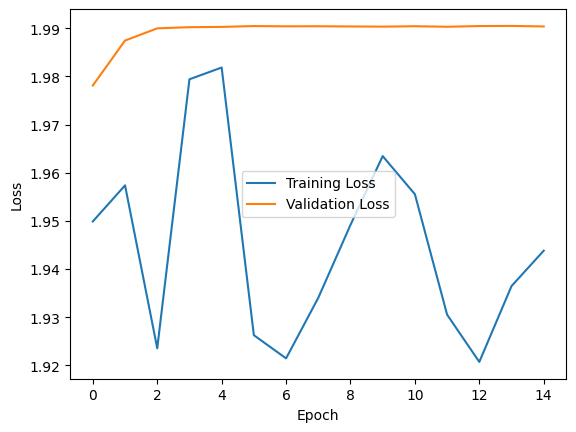

In [27]:
plt.plot(train_losses_CNNLSTM, label='Training Loss')
plt.plot(val_loss_LSTMCNN, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
#Evaluation
CNNLSTMmodel.eval()
all_enhancer_predictions = []
all_enhancer_true = []
all_tissue_predictions = []
all_tissue_true = []

with torch.no_grad():
     for X,y, tissue_labels_batch, mask_batch in validation_loader:
        X,y, tissue_labels_batch, mask_batch = X.to(device),y.to(device), tissue_labels_batch.to(device), mask_batch.to(device)
        predicted_enhancer, predicted_tissue = CNNLSTMmodel(X)
        all_enhancer_predictions.append((predicted_enhancer.squeeze() > 0.1).float())
        all_enhancer_true.append(y)

        active_idx = mask_batch.any(dim=1)
        if active_idx.any():
            all_tissue_predictions.append((predicted_tissue[active_idx] > 0.1).float())
            all_tissue_true.append(tissue_labels_batch[active_idx])

all_enhancer_predictions = torch.cat(all_enhancer_predictions)
all_enhancer_true = torch.cat(all_enhancer_true)
all_tissue_predictions = torch.cat(all_tissue_predictions)
all_tissue_true = torch.cat(all_tissue_true)


In [29]:
all_enhancer_predictions = all_enhancer_predictions.cpu()
all_enhancer_true = all_enhancer_true.cpu()
all_tissue_predictions = all_tissue_predictions.cpu()
all_tissue_true = all_tissue_true.cpu()

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#Evaluation of our CNN model
model.eval()
all_enhancer_logits, all_enhancer_true = [], []
all_tissue_logits, all_tissue_true = [], []

with torch.no_grad():
  for X,y, tissue_labels, mask in validation_loader:
    X,y, tissue_labels, mask = X.to(device),y.to(device), tissue_labels.to(device), mask.to(device)
    predicted_enhancer, predicted_tissue = model(X)

    all_enhancer_logits.append(predicted_enhancer.cpu())
    all_enhancer_true.append(y.cpu())
    all_tissue_logits.append(predicted_tissue.cpu())
    all_tissue_true.append(tissue_labels.cpu())

all_enhancer_logits = torch.cat(all_enhancer_logits, dim=0)
all_enhancer_true = torch.cat(all_enhancer_true, dim=0)
all_tissue_logits = torch.cat(all_tissue_logits, dim=0)
all_tissue_true = torch.cat(all_tissue_true, dim=0)

#Threshold tuning for enhancer
best_Thresh_enhancer, best_f1_enhancer = 0.5, 0
for t in np.arange(0.3, 0.7, 0.5):
  predicted = (torch.sigmoid(all_enhancer_logits) > t).int().numpy()
  f1 = f1_score(all_enhancer_true.numpy().flatten(), predicted.flatten())
  if f1 > best_f1_enhancer:
    best_f1_enhancer = f1
    best_Thresh_enhancer = t
#Threshold tuning for tissue
best_Thresh_tissue, best_f1_tissue = 0.5, 0
for t in np.arange(0.3, 0.7, 0.05):
  predicted = (torch.sigmoid(all_tissue_logits) > t).int().numpy()
  f1 = f1_score(all_tissue_true.numpy().flatten(), predicted.flatten())
  if f1 > best_f1_tissue:
    best_f1_tissue = f1
    best_Thresh_tissue = t

#computing final metrics
enhancer_predicted = (torch.sigmoid(all_enhancer_logits) > best_Thresh_enhancer).int().numpy()
enhancer_true = all_enhancer_true.numpy()
enhancer_accuracy = accuracy_score(enhancer_true, enhancer_predicted)
enhancer_precision = precision_score(enhancer_true, enhancer_predicted, zero_division=0)
enhancer_recall = recall_score(enhancer_true, enhancer_predicted, zero_division=0)
enhancer_f1 = f1_score(enhancer_true, enhancer_predicted, zero_division=0)

tissue_predicted = (torch.sigmoid(all_tissue_logits) > best_Thresh_tissue).int().numpy()
tissue_true = all_tissue_true.numpy()
tissue_accuracy = accuracy_score(tissue_true.reshape(-1, num_tissues).argmax(axis=1), tissue_predicted.reshape(-1, num_tissues).argmax(axis=1))
tissue_precision = precision_score(tissue_true.flatten(), tissue_predicted.flatten(), zero_division=0)
tissue_recall = recall_score(tissue_true.flatten(), tissue_predicted.flatten(), zero_division=0)
tissue_f1 = f1_score(tissue_true.flatten(), tissue_predicted.flatten(), zero_division=0)

print(f'Final Validation Results')
print(f'Enhancer - Accuracy: {enhancer_accuracy:.4f}, Precision: {enhancer_precision:.4f}, Recall: {enhancer_recall:.4f}, F1: {enhancer_f1:.4f}, Best Threshold: {best_Thresh_enhancer}')
print(f'Tissue - Accuracy: {tissue_accuracy:.4f}, Precision: {tissue_precision:.4f}, Recall: {tissue_recall:.4f}, F1: {tissue_f1: .4f}, Best Threshold: {best_Thresh_tissue}')


Final Validation Results
Enhancer - Accuracy: 0.7461, Precision: 0.7461, Recall: 1.0000, F1: 0.8546, Best Threshold: 0.3
Tissue - Accuracy: 0.6612, Precision: 0.1754, Recall: 0.6050, F1:  0.2720, Best Threshold: 0.44999999999999996


In [31]:
torch.save(CNNLSTMmodel.state_dict(), 'dna_cnnlstm.pth')

In [32]:
#Final testing
test_data = DNAdataset(X_test, y_test,tissue_test, mask_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [33]:
model_cnn = DNA_CNN()
model_cnnlstm = DNA_CNNLSTM()

model_cnn.load_state_dict(torch.load('dna_cnn.pth'))
model_cnn.to(device)
model_cnnlstm.load_state_dict(torch.load('dna_cnnlstm.pth'))
model_cnnlstm.to(device)
model_cnn.eval()
model_cnnlstm.eval()


DNA_CNNLSTM(
  (embedding): Embedding(65, 16, padding_idx=64)
  (conv1): Conv1d(16, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(256, 128, batch_first=True, bidirectional=True)
  (fc_enhancer): Linear(in_features=256, out_features=1, bias=True)
  (fc_tissue): Linear(in_features=256, out_features=9, bias=True)
)

In [34]:
def evaluate_model(model, test_loader, device, threshold=0.3):
  model.eval()
  all_enhancer_predictions, all_enhancer_true = [], []
  all_tissue_predictions, all_tissue_true = [], []

  with torch.no_grad():
    for X, y, tissue, mask in test_loader:
      X, y, tissue, mask = X.to(device), y.to(device), tissue.to(device), mask.to(device)
      predicted_enhancer, predicted_tissue = model(X)

      #enhancer task (binary)
      enhancer_prob = torch.sigmoid(predicted_enhancer)
      enhancer_pred = (enhancer_prob > best_Thresh_enhancer).float()

      #tissue task (multi-class)
      tissue_pred_probs = torch.sigmoid(predicted_tissue)
      tissue_predictions = (tissue_pred_probs > best_Thresh_tissue).float()


      all_enhancer_predictions.append(enhancer_pred.cpu())
      all_enhancer_true.append(y.cpu())
      all_tissue_predictions.append(tissue_predictions.cpu())
      all_tissue_true.append(tissue.cpu())
  #converting lists to tensors
  all_enhancer_predictions = torch.cat(all_enhancer_predictions).numpy()
  all_enhancer_true = torch.cat(all_enhancer_true).numpy()
  all_tissue_predictions = torch.cat(all_tissue_predictions).numpy()
  all_tissue_true = torch.cat(all_tissue_true).numpy()


  #evaluation metrics
  enhancer_accuracy = accuracy_score(all_enhancer_true, all_enhancer_predictions)
  enhancer_precision = precision_score(all_enhancer_true, all_enhancer_predictions)
  enhancer_recall = recall_score(all_enhancer_true, all_enhancer_predictions)
  enhancer_f1 = f1_score(all_enhancer_true, all_enhancer_predictions)

  tissue_accuracy = accuracy_score(all_tissue_true, all_tissue_predictions)
  tissue_precision = precision_score(all_tissue_true, all_tissue_predictions, average='micro', zero_division=0)
  tissue_recall = recall_score(all_tissue_true, all_tissue_predictions, average='micro', zero_division=0)
  tissue_f1 = f1_score(all_tissue_true, all_tissue_predictions, average='micro', zero_division=0)

  print(f"Enhancer - Accuracy: {enhancer_accuracy:.4f}, Precision: {enhancer_precision:.4f}, Recall: {enhancer_recall:.4f}, F1: {enhancer_f1:.4f}")
  print(f"Tissue - Accuracy: {tissue_accuracy:.4f}, Precision: {tissue_precision:.4f}, Recall: {tissue_recall:.4f}, F1: {tissue_f1:.4f}")



In [35]:
test_data = DNAdataset(X_test, y_test,tissue_test, mask_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [37]:
print("CNN Model Evaluation Results")
evaluate_model(model_cnn, test_loader, device)
print("CNN-LSTM Model Evaluation Results")
evaluate_model(model_cnnlstm, test_loader, device)

CNN Model Evaluation Results
Enhancer - Accuracy: 0.7598, Precision: 0.7598, Recall: 1.0000, F1: 0.8635
Tissue - Accuracy: 0.1662, Precision: 0.1575, Recall: 0.6195, F1: 0.2511
CNN-LSTM Model Evaluation Results
Enhancer - Accuracy: 0.7598, Precision: 0.7598, Recall: 1.0000, F1: 0.8635
Tissue - Accuracy: 0.0082, Precision: 0.0935, Recall: 0.9870, F1: 0.1708
